In [116]:
%matplotlib inline

from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
from mediapipe.framework.formats import landmark_pb2
from matplotlib import image as mp_image
from IPython.display import Image

import time
import os
import json

In [38]:
classes = open('/home/rdr2143/darknet/data/coco.names').read().strip().split('\n')

In [39]:
net = cv.dnn.readNetFromDarknet('/home/rdr2143/darknet/cfg/yolov2.cfg', '/home/rdr2143/darknet/yolov2.weights')
# net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

In [40]:
def get_image_blob_as_input(file_path):
    img = cv.imread(file_path)
    return cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)

In [41]:
def predict(net, ln, blob):
    net.setInput(blob)
    return net.forward(ln)

In [195]:
def get_number_of_people_detected(outputs):
    count = 0
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.25 and classID == 0:
                count += 1
    return count

def run_inference_and_get_count(images):
    c = 0
    data = {}
    for i, each_image in enumerate(images):
        if i % 50 == 0:
            print(f'Completed: {i}')
        blob = get_image_blob_as_input(each_image)
        outputs = predict(net, ln, blob)
        temp = get_number_of_people_detected(outputs)
        data[each_image] = temp
        c += temp
    return c, data

In [122]:
def infer_and_write(name, patched_images, og_images):
    patched_people, patched_data = run_inference_and_get_count(patched_images)
    og_people, og_data = run_inference_and_get_count(og_images)
    
    print(f'Converage ratio: {patched_people/og_people * 100}')
    return patched_data, patched_people, og_data, og_people

def write_to_files(name, og_data, patched_data):
    with open(name+"_patched.json", "w") as p_results:
        p_results.write(json.dumps(patched_data))

    with open(name+"_og.json", "w") as og_results:
        og_results.write(json.dumps(og_data))

In [218]:
OG_BASE = '/home/rdr2143/waymo-adv-dataset/single-failed-v1-pose/og/'
PATCHED_BASE = '/home/rdr2143/waymo-adv-dataset/single-failed-v1-pose/patched/'
og_images = [OG_BASE + x for x in os.listdir(OG_BASE)]
patched_images = [PATCHED_BASE + x for x in os.listdir(PATCHED_BASE)]
patched_data, patched_people, og_data, og_people = infer_and_write("waymo_pose_results_v1", patched_images, og_images)

write_to_files("waymo_pose_results_v1", og_data, patched_data)

Completed: 0
Completed: 50
Completed: 100
Completed: 150
Completed: 200
Completed: 250
Completed: 300
Completed: 350
Completed: 400
Completed: 450
Completed: 0
Completed: 50
Completed: 100
Completed: 150
Completed: 200
Completed: 250
Completed: 300
Completed: 350
Completed: 400
Completed: 450
Converage ratio: 39.726027397260275


In [204]:
OG_BASE_r = '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/og/'
PATCHED_BASE_r = '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/'
og_images_r = [OG_BASE_r + x for x in os.listdir(OG_BASE_r)]
patched_images_r = [PATCHED_BASE_r + x for x in os.listdir(PATCHED_BASE_r)]
patched_data_r, patched_people_r, og_data_r, og_people_r = infer_and_write("waymo_regular_results_v1", patched_images_r, og_images_r)

write_to_files("waymo_regular_results_v1", og_data_r, patched_data_r)

Completed: 0
Completed: 50
Completed: 100
Completed: 150
Completed: 200
Completed: 250
Completed: 300
Completed: 350
Completed: 400
Completed: 450
Completed: 0
Completed: 50
Completed: 100
Completed: 150
Completed: 200
Completed: 250
Completed: 300
Completed: 350
Completed: 400
Completed: 450
Converage ratio: 44.52054794520548


In [128]:
def get_mismatches(patched_data, og_data):
    transformed_patched_data = {}
    for k, v in patched_data.items():
        transformed_patched_data[str(k.split("/")[-1].split("_")[0])] = v
    
    mismatches = []
    for k, v in og_data.items():
        label = str(k.split("/")[-1].split("_")[0])
        if label in transformed_patched_data:
            diff = abs(transformed_patched_data[label] - v)
            if diff:
                mismatches.append(k)
            
    return mismatches

In [132]:
OG_BASE_r = '/home/rdr2143/inria-adv-dataset/single-failed-v2-regular/og/'
PATCHED_BASE_r = '/home/rdr2143/inria-adv-dataset/single-failed-v2-regular/patched/'
og_images_r = [OG_BASE_r + x for x in os.listdir(OG_BASE_r)]
patched_images_r = [PATCHED_BASE_r + x for x in os.listdir(PATCHED_BASE_r)]
patched_data_r, patched_people_r, og_data_r, og_people_r = infer_and_write("regular_results_v1", patched_images_r, og_images_r)

Completed: 0
Completed: 50
Completed: 0
Completed: 50
Converage ratio: 47.87234042553192


In [141]:
# #Good examples:
# from IPython.display import Image as IpythonImage
# # IpythonImage(filename='/home/rdr2143/inria-adv-dataset/single-failed-patched/patched/29_patched_img.jpg')
# # IpythonImage(filename='/home/rdr2143/inria-adv-dataset/patched/103_patched_img.jpg') 
# IpythonImage(filename='/home/rdr2143/adversarial-yolo/inria/Train/pos/crop001017.png') 

In [241]:
missed_opportunities = []
for img_file, v in patched_data_r.items():
    img = img_file.split("/")[-1]
    if (patched_data[PATCHED_BASE+img] < v):
        additional_success+=1
        missed_opportunities.append(img_file)

# for ima in missed_opportunities:
#     img = mp_image.imread(ima)
#     plt.figure()
#     plt.imshow(img)

In [242]:
missed_opportunities

['/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/393_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/362_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/12_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/330_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/14_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/346_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/337_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/441_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/178_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/244_patched_img.jpg',
 '/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/25_patched_img.jpg',
 '/home/rdr2143/waymo-ad

In [194]:
additional_success/(og_people_r - patched_people_r)

0.2653061224489796

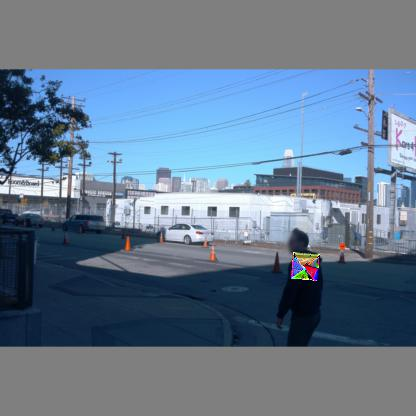

In [245]:
from IPython.display import Image as IpythonImage
IpythonImage(filename='/home/rdr2143/waymo-adv-dataset/single-failed-v1-regular/patched/437_patched_img.jpg') 

In [187]:
run_inference_and_get_count(['/home/rdr2143/inria-adv-dataset/single-failed-v2-pose/patched/73_patched_img.jpg',
                            '/home/rdr2143/inria-adv-dataset/single-failed-v2-regular/patched/73_patched_img.jpg',
                            '/home/rdr2143/inria-adv-dataset/single-failed-v2-regular/og/73_og_img.jpg'])

Completed: 0
0.7766999 0
0.83087915 0


(2,
 {'/home/rdr2143/inria-adv-dataset/single-failed-v2-pose/patched/73_patched_img.jpg': 1,
  '/home/rdr2143/inria-adv-dataset/single-failed-v2-regular/patched/73_patched_img.jpg': 0,
  '/home/rdr2143/inria-adv-dataset/single-failed-v2-regular/og/73_og_img.jpg': 1})

In [189]:
patched_people_r

45

In [190]:
og_people_r

94